In [4]:
import numpy as np
import pandas as pd
import os
import gc
import configparser
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
%matplotlib inline

pal = sns.color_palette()

import cv2
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls

settings = configparser.ConfigParser()
settings.read('amazon.cfg')
data_dir = settings.get('data', 'data_dir')
print(data_dir)

D:/Downloads/amazon/


C:\Users\Me\Anaconda2\lib\site-packages\ipykernel\__main__.py:20: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.


In [1]:

#print('# File sizes')
#for f in os.listdir(data_dir):
#    if not os.path.isdir(data_dir + f):
#        print(f.ljust(30) + str(round(os.path.getsize(data_dir + f) / 1000000, 2)) + 'MB')
#    else:
#        sizes = [os.path.getsize(data_dir+f+'/'+x)/1000000 for x in os.listdir(data_dir + f)]
#        print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))

# File sizes
models                        12.0MB (2 files)
preprocess                    0.0MB (3 files)
sample_submission.csv         1.0MB (2 files)
test-jpg                      0.0MB (40669 files)
test-tif.tar.7z               13298.0MB
train-jpg                     0.0MB (40479 files)
train-jpg-sample              0.0MB (100 files)
train-tif-sample              0.0MB (100 files)
train-tif.tar                 21848.0MB
train-tif.tar.7z              13233.0MB
train.csv                     1.0MB
__MACOSX                      0.0MB (1 files)


In [22]:
df_train = pd.read_csv(data_dir + 'train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


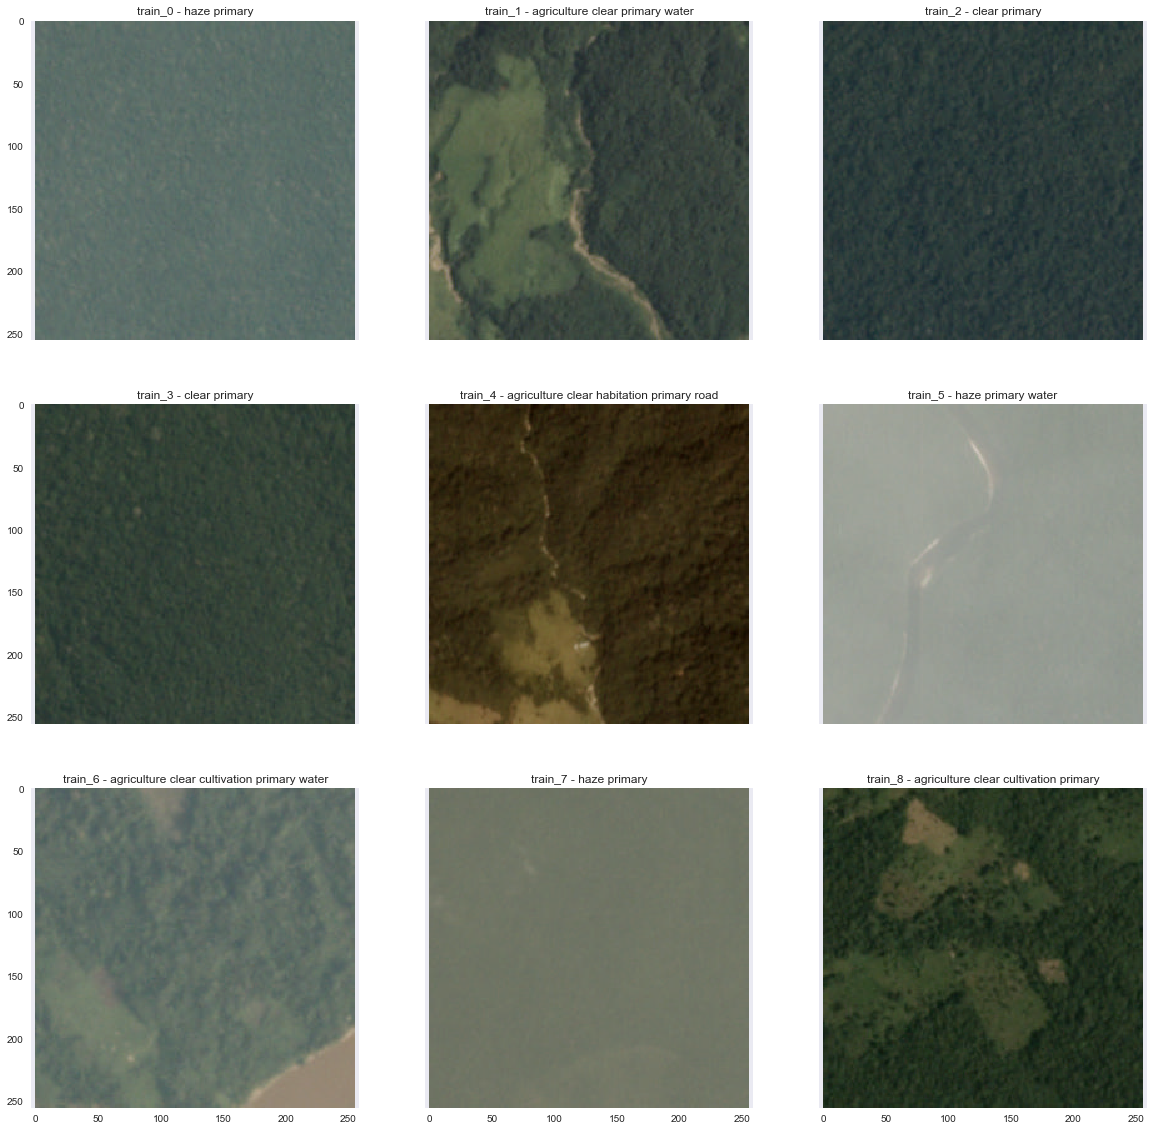

In [6]:


new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:9].values:
    img = cv2.imread(data_dir + 'train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    i += 1
    
plt.show()

In [4]:
all_tags = [item for sublist in list(df_train['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))

total of 116484 non-unique tags in all training images


In [5]:
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head()

,tag,0
12,primary,37840
5,clear,28203
0,agriculture,12338
13,road,8076
16,water,7262


In [6]:
tags_counted_and_sorted.tail()

,tag,0
1,artisinal_mine,339
3,blooming,332
15,slash_burn,209
4,blow_down,101
7,conventional_mine,100


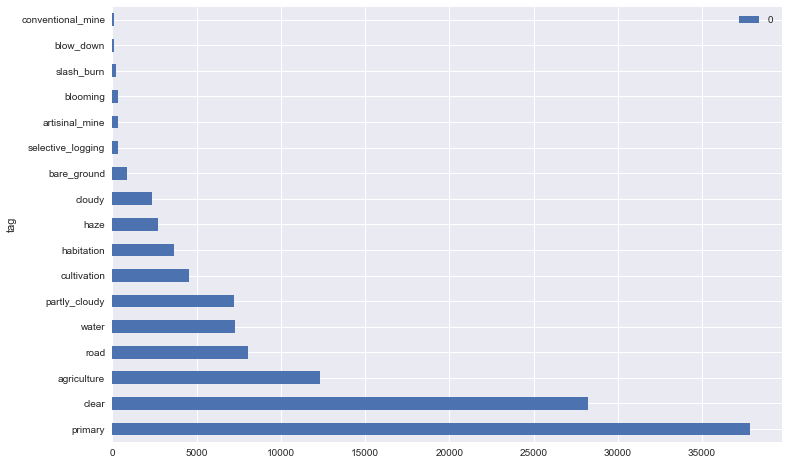

In [6]:
tags_counted_and_sorted.plot.barh(x='tag', y=0, figsize=(12,8))

In [7]:
# let's visualize NIR band
# not installing osgeo due to dependency conflict concern
# http://ceholden.github.io/open-geo-tutorial/python/chapter_3_visualization.html

tiff_filename = 'D:/Downloads/amazon/train-tif-sample/train_10.tif'
jpg_filename = 'D:/Downloads/amazon/train-jpg-sample/train_10.jpg'

(256L, 256L, 4L)


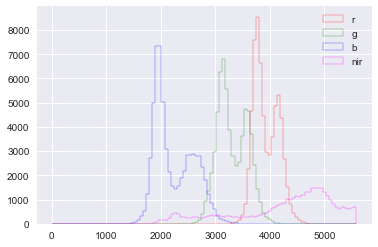

In [6]:
# equivalent ways to load an image into array using cv2 and scikit-image
#import cv2
#rgbn_image = cv2.imread(tiff_filename, cv2.IMREAD_UNCHANGED)
rgbn_image = io.imread(tiff_filename)

print(rgbn_image.shape)

# extract the rgb values
rgb_image = rgbn_image[:,:,:3]

# extract the different bands
r, g, b, nir = rgbn_image[:, :, 0], rgbn_image[:, :, 1], rgbn_image[:, :, 2], rgbn_image[:, :, 3]

def plot_rgbn_histo(r, g, b, n):
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'), (nir, 'nir', 'magenta')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,rgb_image.max()], 
                 label=name, color=color, histtype='step')
    plt.legend()

# plot a histogram of rgbn values
plot_rgbn_histo(r, g, b, nir)




(256L, 256L, 3L)


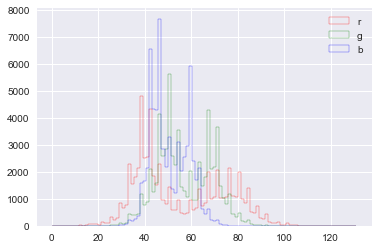

In [9]:

rgb_image = io.imread(jpg_filename)

print(rgb_image.shape)

# extract the different bands
r, g, b = rgb_image[:, :, 0], rgb_image[:, :, 1], rgb_image[:, :, 2]

def plot_rgb_histo(r, g, b):
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,rgb_image.max()], 
                 label=name, color=color, histtype='step')
    plt.legend()

# plot a histogram of values
plot_rgb_histo(r, g, b)

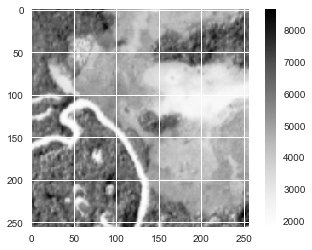

In [19]:
# visualize the NIR band
plt.imshow(rgbn_image[:, :, 3])
plt.colorbar()



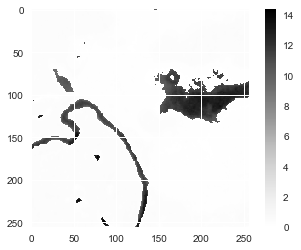

In [23]:
# NDWI (water) = (green-nir)/(green+nir)
def compute_ndwi(rgbn_img):
    ndwi = (rgbn_img[:, :, 3] - rgbn_img[:, :, 1]) / \
        (rgbn_img[:, :, 3] + rgbn_img[:, :, 1]).astype(np.float64)
    return ndwi

plt.imshow(compute_ndwi(rgbn_image))
plt.colorbar()

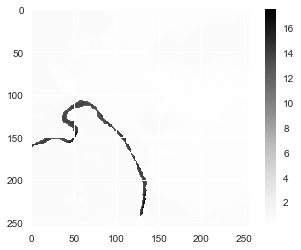

In [24]:
# NDVI (vegetations supposedly)
def compute_ndvi(rgbn_img):
    ndvi = (rgbn_img[:, :, 3] - rgbn_img[:, :, 2]) / \
        (rgbn_img[:, :, 3] + rgbn_img[:, :, 2]).astype(np.float64)
    return ndvi
plt.imshow(ndvi)
plt.colorbar()    

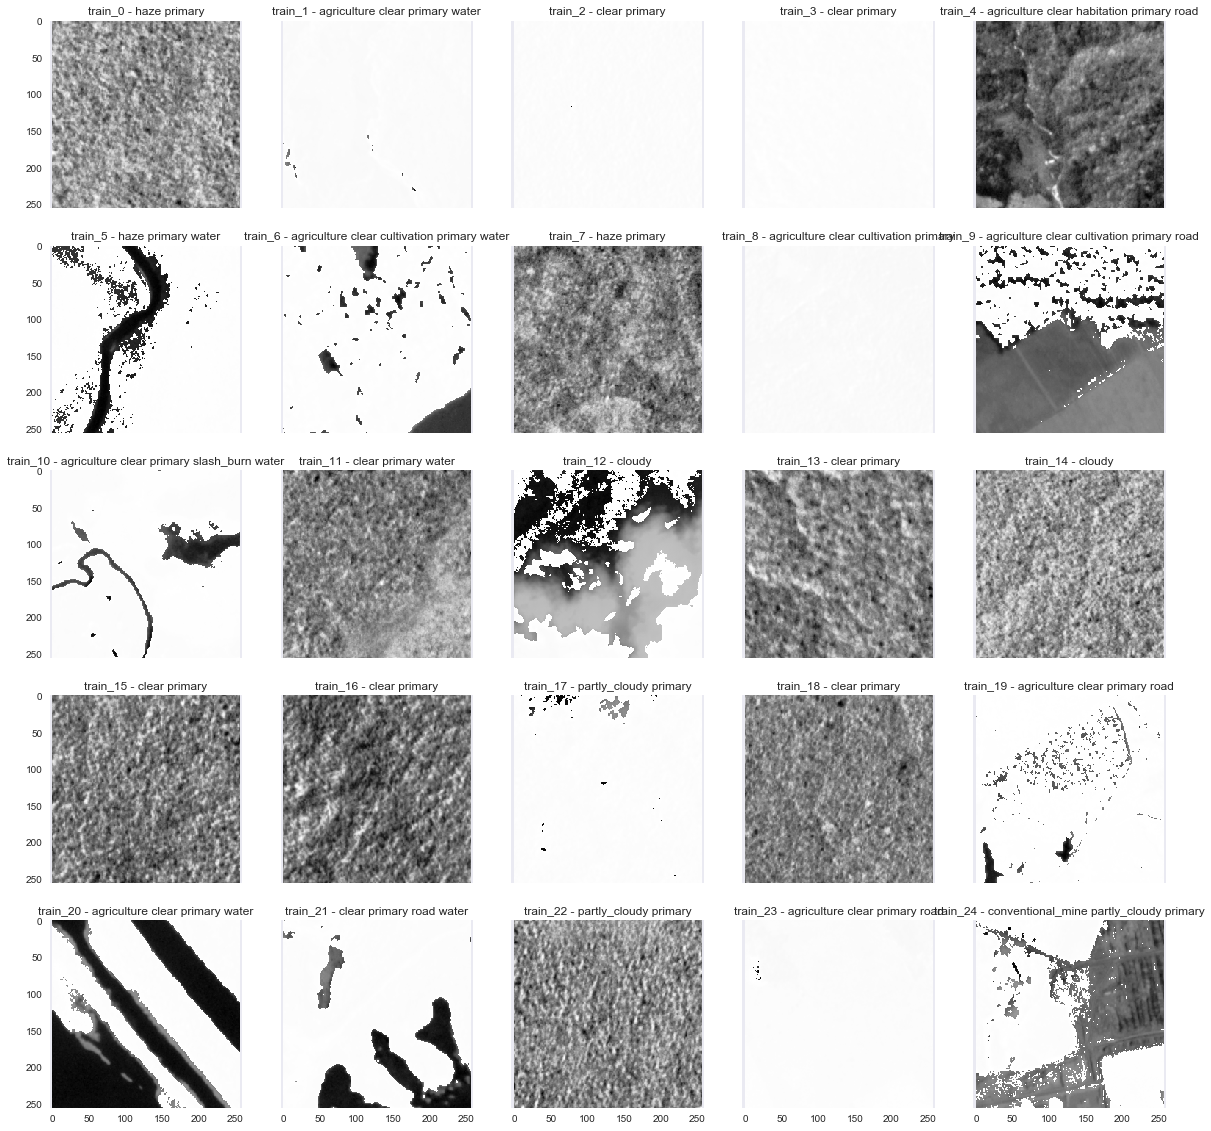

In [26]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:25].values:
    img = io.imread(data_dir + 'train-tif-v2/{}.tif'.format(f))
    ax[i // 5, i % 5].imshow(compute_ndwi(img))
    ax[i // 5, i % 5].set_title('{} - {}'.format(f, l))
    i += 1
    
plt.show()